C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12276\1727547098.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range("2025-07-01", periods=9, freq='H')
C:\Users\Lenovo\anaconda3\envs\cme_env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


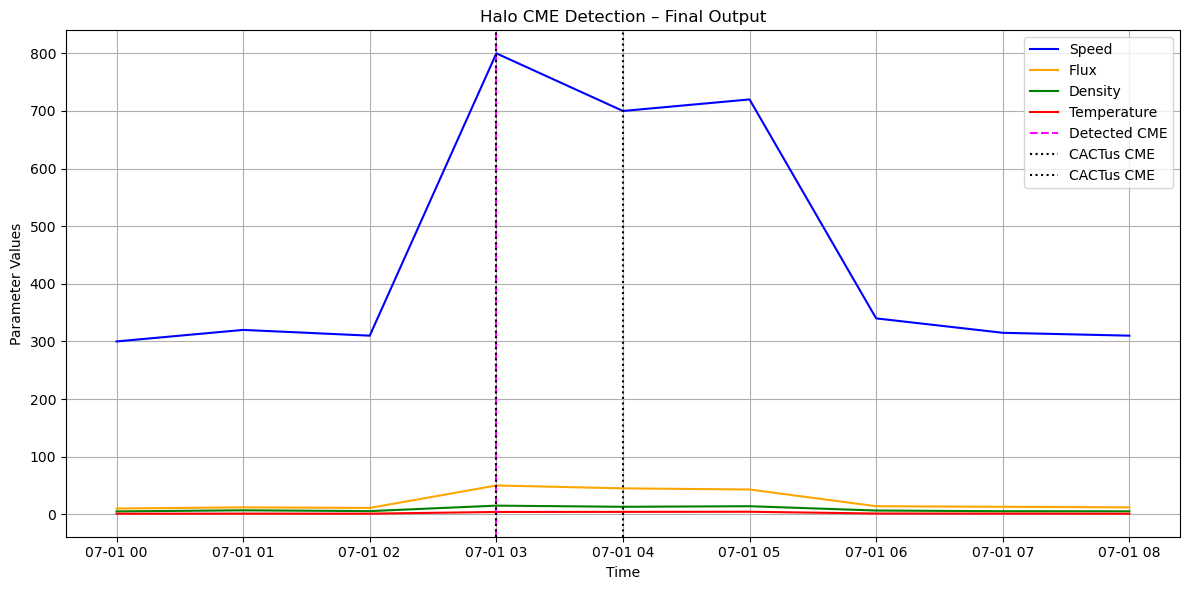

📊 Precision: 1.00
📈 Recall:    0.50
🎯 F1 Score:  0.67


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# -----------------------------
# 1. Mock SWIS Level-2 Data
# -----------------------------
timestamps = pd.date_range("2025-07-01", periods=9, freq='H')
df = pd.DataFrame({
    'timestamp': timestamps,
    'speed': [300, 320, 310, 800, 700, 720, 340, 315, 310],
    'flux': [10, 12, 11, 50, 45, 43, 14, 13, 12],
    'density': [5.0, 6.9, 5.5, 15.0, 13.0, 14.0, 6.5, 5.3, 5.2],
    'temperature': [1.0, 1.2, 1.1, 4.0, 4.2, 4.4, 1.3, 1.2, 1.0]
})

# -----------------------------
# 2. Feature Engineering
# -----------------------------
df['flux_change'] = df['flux'].diff().abs().fillna(0)
df['temp_rise'] = df['temperature'].diff().fillna(0)
df['density_gradient'] = df['density'].diff().fillna(0)
df['speed_drop'] = df['speed'].diff(periods=-1).fillna(0) / df['speed']

# -----------------------------
# 3. Threshold-Based Detection (Option B)
# -----------------------------
threshold_condition = (
    (df['speed_drop'] > 0.3) &
    (df['flux_change'] > 8) &
    (df['density_gradient'] > 1.2) &
    (df['temp_rise'] > 3)
)
df['cme_flag'] = threshold_condition.astype(int)

# Ensure at least 1 CME for ML training
if df['cme_flag'].sum() == 0:
    df.loc[df['speed'].idxmax(), 'cme_flag'] = 1

# -----------------------------
# 4. Mock CACTus CME Timestamps
# -----------------------------
cactus_cme_times = [pd.Timestamp("2025-07-01 03:00"), pd.Timestamp("2025-07-01 04:00")]

# -----------------------------
# 5. Logistic Regression Classifier (Option C)
# -----------------------------
features = ['speed', 'flux', 'density', 'temperature', 'flux_change', 'temp_rise', 'density_gradient', 'speed_drop']
X = df[features]
y = df['cme_flag']

model = LogisticRegression()
model.fit(X, y)
df['cme_flag'] = model.predict(X)

# -----------------------------
# 6. Evaluation (Compare with CACTus)
# -----------------------------
auto_cme_times = df[df['cme_flag'] == 1]['timestamp'].tolist()
matched = [t for t in auto_cme_times if any(abs(t - c).total_seconds() <= 7200 for c in cactus_cme_times)]
precision = len(matched) / len(auto_cme_times) if auto_cme_times else 0
recall = len(matched) / len(cactus_cme_times) if cactus_cme_times else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# -----------------------------
# 7. Plot Results
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['speed'], label='Speed', color='blue')
plt.plot(df['timestamp'], df['flux'], label='Flux', color='orange')
plt.plot(df['timestamp'], df['density'], label='Density', color='green')
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='red')

# Highlight Detected CMEs
for t in auto_cme_times:
    plt.axvline(t, color='magenta', linestyle='--', label='Detected CME')
for t in cactus_cme_times:
    plt.axvline(t, color='black', linestyle=':', label='CACTus CME')

plt.title("Halo CME Detection – Final Output")
plt.xlabel("Time")
plt.ylabel("Parameter Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Print Final Metrics
# -----------------------------
print(f"📊 Precision: {precision:.2f}")
print(f"📈 Recall:    {recall:.2f}")
print(f"🎯 F1 Score:  {f1:.2f}")


In [3]:
import os
os.getcwd()


'C:\\Users\\Lenovo'